## Import Modules


In [1]:
import pandas as pd
import numpy as np

from  cbcdb import DBManager
import datetime
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc,  mean_squared_error, explained_variance_score, r2_score, f1_score, recall_score, precision_score, classification_report
import statsmodels.api as sm



def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

## Read in Data

In [2]:
load_dotenv(find_dotenv())
db = DBManager()

In [3]:
sql = """
        create temporary table consecutive_days as (
            select uid
                 , datetime_
                 , rank_group
                 , visit_number
                 , max(visit_number) over (partition by uid) as max_num_visit
                 , case
                       when (max_num_visit) > 1 then 1
                       else 0 end                            as visit_more_than_once
            from (
                     select uid
                          , datetime_
                          , rank_group
                          , rank() over (partition by uid order by rank_group asc) as visit_number
                     from (
                              SELECT uid
                                   , datetime                                                                  as datetime_
                                   , dateadd(day, -rank() OVER (partition by uid ORDER BY datetime), datetime) AS rank_group
                              FROM (SELECT DISTINCT t.location_id || '_' || t.animal_id as uid
                                                  , trunc(t.datetime_date)              as datetime
                                                    , sum(t.revenue) as revenue_
                                    from bi.transactions t
                                             inner join bi.animals a
                                                        on a.ezyvet_id = t.animal_id
                                                            and a.location_id = t.location_id
                                    group by 1,2
                              having revenue_ > 0
                                    order by 1, 2))));
        
        create temporary table wellness as (
            select wm.location_id || '_' || wm.animal_id                 as uid
                 , date(datetime_start_date)                             as datetime_
                 , wm.wellness_plan                                      as wellness_plan_num
                 , DATEDIFF(MONTH, wm.datetime_start_date, CURRENT_DATE) as months_a_member
                 , wp.name                                               as wellness_plan
            from pwa_bi.bi.wellness_membership wm
                     left join bi.wellness_plans wp
                               on wp.location_id = wm.location_id
                                   and wp.ezyvet_id = wm.wellness_plan
                     left join bi.animals a
                               on a.location_id = wm.location_id
                                   and a.ezyvet_id = wm.animal_id);
        -- where wp.active = 1
        --  and wm.status = 'Active');
        
            select f1.uid
             , f1.breed
             , f1.ani_age
             , f1.date
             , f1.weight
             , f1.is_medical
             , f1.product_group
             , f1.product_name
             ,  sum(case when f1.product_name like 'First Day Daycare Fre%' then 1 else 0 end)
                     over (partition by f1.uid)  as product_count
             --, f1.type_id
             , f1.wellness_plan
             --, f1.months_a_member
             , f1.visit_number
             , f1.visit_more_than_once
             , f1.max_num_visit
             , f1.first_visit_spend
             , f1.total_future_spend
        from (
                     select f.uid
                      , f.breed
                      , f.ani_age
                      , f.date
                      , f.weight
                      , f.is_medical
                      --, f.tracking_level
                      , f.product_group
                      , f.product_name
                      --, f.type_id
                      , cd.visit_number
                      , cd.visit_more_than_once
                      , cd.max_num_visit
                      , f.revenue
                      ,  sum(case when w.wellness_plan is null then 0 else 1 end)
                        over (partition by f.uid)  as wellness_plan
                      --, w.months_a_member
                      , sum(case when cd.visit_number != 1 then f.revenue else 0 end)
                        over (partition by f.uid) as total_future_spend
                      , sum(case when cd.visit_number = 1 then f.revenue else 0 end)
                        over (partition by f.uid) as first_visit_spend
                 from (

                          select t.location_id || '_' || t.animal_id                                                         as uid
                               , a.breed
                               , max(
                                  date_diff('years', timestamp 'epoch' + a.date_of_birth * interval '1 second',
                                            current_date))                                                                   as ani_age
                               --, min(trunc(t.datetime_date)) over (partition by t.location_id || '_' || t.animal_id) as      date_of_first_visit
                               , case when trunc(t.datetime_date) - min(trunc(t.datetime_date)) over (partition by t.location_id || '_' || t.animal_id) > 548 then 0
                                   else 1 end as less_than_1_5_yeras
                                , case when current_date - min(trunc(t.datetime_date)) over (partition by t.location_id || '_' || t.animal_id) <  270 then 0
                                   else 1 end as recent_patient
                               , trunc(t.datetime_date)                                                                      as date
                               , a.weight
                               , p.is_medical
                                , case when  p.product_group like 'Retail%' then 'Retail'
                                        when p.product_group in ('Boarding','Daycare','Daycare Packages') then 'Boarding'
                                        when p.product_group like 'Medication%' then 'Medication'
                                        when p.product_group like  ('Referrals%') then 'Referrals'
                                        when p.product_group in ('to print','To Print','Administration') then 'admin'
                                        else p.product_group end as product_group
                               , case
                                     when apt.type_id like 'Grooming%' then 'groom'
                                     when apt.type_id like '%Neuter%' then 'neurtering'
                                     when apt.type_id like '%ental%' then 'dental'
                                     else apt.type_id end                                                                    as type_id
                               --, p.name
                               --, p.type
                               --, p.tracking_level
                               , t.product_name
                               , sum(t.revenue)                                                                                   as revenue
                               , dense_rank()
                                 over (partition by t.location_id || '_' || t.animal_id order by trunc(t.datetime_date) asc) as rank_
                          from bi.transactions t
                                   --inner join bi.products p
                                   left join bi.products p
                                              on t.product_id = p.ezyvet_id
                                                  and t.location_id = p.location_id
                                   left join bi.animals a
                                              on a.id = t.animal_id
                                   left join bi.contacts c
                                             on a.contact_id = c.ezyvet_id
                                                 and t.location_id = c.location_id
                                   left join bi.appointments apt
                                             on a.contact_id = apt.ezyvet_id
                                                 and t.location_id = apt.location_id
                                --where t.product_name like 'First Day Daycare Free%'
                                -- type_id not in ('Cancellation')
                                -- p.name not like '%Subscri%'
                                --  and p.product_group != 'Surgical Services'
                                -- and a.breed != '0.0'
                          group by 1, 2, 6, 7, 8, 9, 10, 11
                     ) f
                  inner join consecutive_days cd
                            on f.uid = cd.uid
                                and f.date = cd.datetime_
                  left join wellness w
                            on f.uid = w.uid
                                and f.date = w.datetime_
                    where less_than_1_5_yeras = 1
                            and recent_patient = 1) f1
        --where f1.visit_number = 1
        order by 1, 4;"""
df = db.get_sql_dataframe(sql)
#df.to_csv('customer_retention_prod/data/data.csv')

2021-08-19 15:28:36,258| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa


In [4]:
df_breed = db.get_sql_dataframe("select * from bi.breeds")
df = df.merge(df_breed, on=['breed'])

2021-08-19 15:28:43,552| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa


In [5]:
        print(
            f"Out of {df.uid.nunique()}, there are {df[((df.weight.isnull()) | (df.weight == 0.0))]['uid'].nunique()} animals with null weight)")
        print(f"Out of {df.uid.nunique()}, there are {df[df.ani_age.isnull()]['uid'].nunique()} animals with null age)")

        print(f"Number of unique id\'s : {df.uid.nunique()}")
        print(f"There are {df[df.total_future_spend > 5000]['uid'].nunique()} patients who have spent more than 5k")
        print(
            f"There are {df[df.total_future_spend < 0]['uid'].nunique()} patients who have somehow spent less than $0")
        df.reset_index(drop=True, inplace=True)
        df_ = df[['uid', 'ani_age', 'weight', 'product_group', 'breed_group', 'tier', 'is_medical',
                  'wellness_plan', 'first_visit_spend', 'total_future_spend']]

Out of 2060, there are 581 animals with null weight)
Out of 2060, there are 484 animals with null age)
Number of unique id's : 2060
There are 24 patients who have spent more than 5k
There are 0 patients who have somehow spent less than $0


## Create categorical df. Number of rows should equate to the number of unique uid

In [6]:
cat_features = ['wellness_plan', 'breed_group', 'tier']
df_cat = df_[['uid'] + cat_features].drop_duplicates()
# df_product_group = pd.get_dummies(df_.product_group)
df_breed_group = pd.get_dummies(df_cat.breed_group)
df_tier = pd.get_dummies(df_cat.tier)

df_cat = pd.concat([df_cat[['uid']],
                    # df_cat.product_group,
                    df_breed_group,
                    df_tier], axis=1)  #
df_categories = df_cat.groupby(['uid'], as_index=False).max()

# Create Continuous df

In [22]:
df.groupby(['is_medical'])['first_visit_spend'].mean()

is_medical
0    139.773264
1    210.730066
Name: first_visit_spend, dtype: float64

In [23]:
cont_features = ['ani_age', 'weight', 'breed_group', 'is_medical', 'wellness_plan', 'first_visit_spend',
                'total_future_spend']
df_cont = df_[['uid'] + cont_features].drop_duplicates()

# look into a binary indicator for weight
df_cont['ani_age'] = df_cont['ani_age'].fillna((df_cont['ani_age'].mean()))
df_cont['weight'] = df_cont['weight'].replace(0, np.nan)
df_cont['weight'] = df_cont.groupby(['ani_age', 'breed_group'])['weight'].transform(
lambda x: x.fillna(x.mean()))
df_cont['weight'] = df_cont.groupby(['breed_group'])['weight'].transform(lambda x: x.fillna(x.mean()))

df_cont = df_cont.groupby(['uid', 'ani_age', 'weight', 'first_visit_spend', 'total_future_spend'],
                        as_index=False).agg(
is_medical_max=('is_medical', 'max'),
is_medical_count=('is_medical', 'count'),
wellness_plan_max=('wellness_plan', 'max'),
wellness_plan_count=('wellness_plan', 'count')
)

df_final = df_cont.merge(df_categories, on='uid')
df_final['total_future_spend'] = df_final.total_future_spend.apply(lambda x: 5000 if x > 5000 else x)
df_final['total_future_spend'] = df_final['total_future_spend'].apply(lambda x: 0 if x < 0 else x)
# self.df_final = self.df_final[((self.df_final.ani_age.notnull()) & (self.df_final.weight.notnull()))]
# self.df_final['weight'] = self.df_final['weight'].fillna((self.df_final['weight'].mean()))
# self.df_final['weight'] = self.df_final['weight'].apply(lambda x: self.df_final['weight'].mean() if x == 0 else x)

# Get dummies on tier and breed group
bins = [0, 1, 200, 350, 500, 1000, 99999]
labels = [0, 1, 2, 3, 4, 5]
df_final['total_future_spend_bin'] = pd.cut(df_final['total_future_spend'], bins=bins, include_lowest=True,
                                labels=labels)
print(f"Value Counts for labels: {df_final['total_future_spend_bin'].value_counts()}")

ValueError: Bin labels must be one fewer than the number of bin edges

### How are we seeing spend with cancellation

In [17]:
final_columns = list(df_final.columns)
for i in ['uid', 'total_future_spend', 'total_future_spend_bin']:
    final_columns.remove(i)

X = df_final[final_columns]
y = df_final['total_future_spend_bin'].apply(lambda x: int(x))
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

In [18]:
import xgboost as xgb

In [19]:
X_train

,ani_age,weight,first_visit_spend,is_medical_max,is_medical_count,wellness_plan_max,wellness_plan_count,cat,companion,herding,...,sporting,terrier,toy,working,None,fancy_cat,regular_cat,tier_1,tier_2,tier_3
266,6.0,103.000000,30.00,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1133,3.0,10.150000,57.05,1,2,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1480,13.0,19.570588,272.00,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1839,4.0,55.000000,112.00,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
67,2.0,7.000000,25.00,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2.0,20.000000,245.88,1,2,0,2,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1095,11.0,25.000000,65.00,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1130,4.0,26.000000,50.00,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1294,7.0,75.000000,135.00,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param = {'max_depth': 5, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = ['auc']
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)


XGBoostError: [15:29:44] ../src/objective/regression_obj.cu:103: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000187ec0074 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x0000000187fc9649 xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 1465
  [bt] (2) 3   libxgboost.dylib                    0x0000000187f6fff4 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 612
  [bt] (3) 4   libxgboost.dylib                    0x0000000187ec4627 XGBoosterUpdateOneIter + 151
  [bt] (4) 5   libffi.7.dylib                      0x000000010d595e9d ffi_call_unix64 + 85
  [bt] (5) 6   ???                                 0x00007ffee321d2a0 0x0 + 140732709065376



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

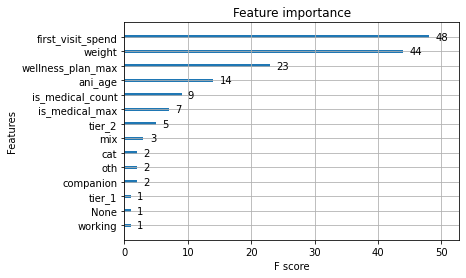

In [ ]:
xgb.plot_importance(bst)


In [21]:
y_test.value_counts()

0    195
2     54
1     50
3     38
5     38
4     37
Name: total_future_spend_bin, dtype: int64

In [14]:
len(X_train)

1648

In [15]:
len(X_test)

412